# Classificazione Multiclasse - Albero Decisionale


In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
import sys
sys.path.append('../Scripts')
from utility import evaluate_and_save_model_multiclass
import os

In [2]:
X_train = pd.read_csv("../data/splitted_category/X_train.csv")
X_test = pd.read_csv("../data/splitted_category/X_test.csv")
y_train = pd.read_csv("../data/splitted_category/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted_category/y_test.csv").values.ravel()


Viene istanziato un albero decisionale con class_weight='balanced' per gestire classi sbilanciate

In [3]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced',	random_state=42 )

model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Nota
La funzione ausiliaria che viene utilizzata per i problemi di classificazione multiclasse a differenza della funzione vista finora per i problemi di classificazione binaria usa average='macro' per il calcolo delle metriche come f1_score, precision_score e recall_score. Questo perché nel contesto in cui si hanno classi sbilanciate, average='macro' è una media semplice non pesata:
- calcola le metriche separatamente per ciascuna classe
- poi fa la media artimetica dei risultati

In [4]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate_and_save_model_multiclass(
    model,
    "decision tree category default gini",
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    "../results/classification_category/decision tree",
    "../models/decision_tree_category.joblib"
)






# GridSearchCV
- viene definita una griglia con diversi parametri: max_depth, criterio, min_samples_split e min_samples_leaf
- come metriche di valutazione viene usato accuracy, precision, f1, recall
l'obiettivo è trovare la migliore combinazione di parametri per un albero decisionale.
Viene scelto di ottimizzare f1_weighted perché nel contesto di problemi di classificazione multiclasse con classi sbilanciate la metrica f1_weighted è una scelta più robusta rispetto ad accuracy. In particolare f1_weighted è una media pesata degli f1_score, bilancia quindi l'importanza delle classi frequenti e rare.
In particolare sono state testate anche altri parametri di scoring: accuracy, f1_macro basta cambiare all'interno di GridSearchCV(..) il parametro scoring, ovviamente otteniamo diverse combinazioni dei parametri. A tal fine la scelta di usare f1_weighted è risultata essere la più opportuna 

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



param_grid = {
    'max_depth': list(range(2, 20)),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10,15,20,25,30,35,40,50,80,100],
    'min_samples_leaf': [1, 2, 5,10,15,35,55,75,110,150]
}
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1_weighted': 'f1_weighted'
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring=scoring,
    refit='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Migliori iperparametri trovati:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


c:\Users\angel\OneDrive\Desktop\DataMiningProject\.venv\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


Migliori iperparametri trovati: {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 15}


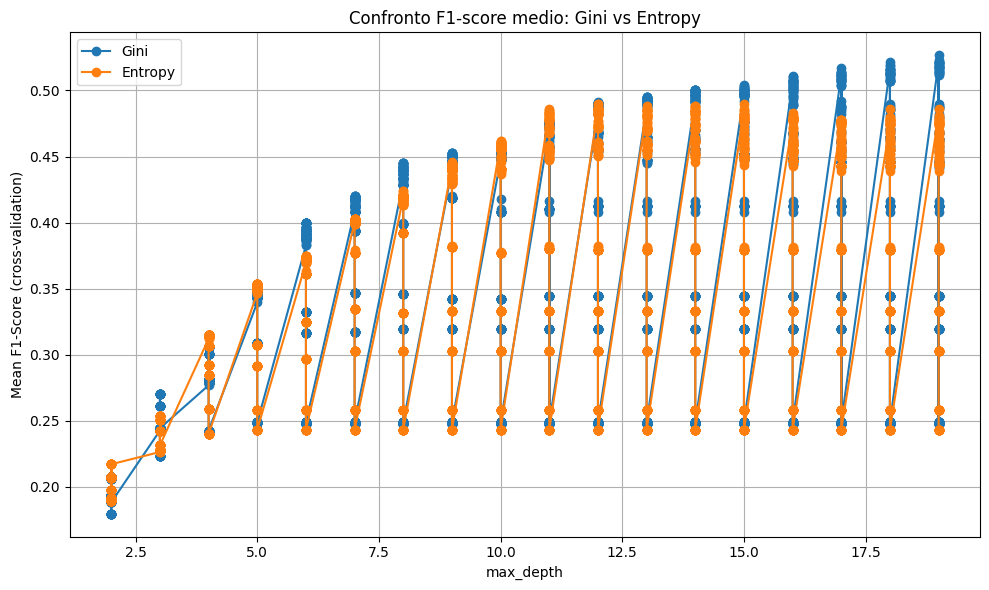

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(grid.cv_results_)

plt.figure(figsize=(10, 6))
for criterion in results_df["param_criterion"].unique():
    subset = results_df[results_df["param_criterion"] == criterion]
    plt.plot(subset["param_max_depth"], subset["mean_test_f1_weighted"], marker='o', label=criterion.capitalize())

plt.title("Confronto F1-score medio: Gini vs Entropy")
plt.xlabel("max_depth")
plt.ylabel("Mean F1-Score (cross-validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/classification_category/decision tree/f1_score_confronto.png")
plt.show()
plt.close()